# Apply Encoder of Transformer Model (Self Attention) to Explore RNA-Protein Binding

In [1]:
import pandas as pd
import tensorflow as tf
from keras import layers
from keras.callbacks import EarlyStopping
#import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer, KBinsDiscretizer
from sklearn.pipeline import Pipeline, make_pipeline
import datetime

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

## Data preparation

In [2]:
df_preprocess = pd.read_excel('data/source data.xlsx')

# df_preprocess.columns = ['promoter', 'fluorescence']
# df_preprocess.head()
# df  = df_preprocess


In [3]:
df = df_preprocess[['Promoter_x', 'strength']]
df.head()
df.columns = ['promoter','fluorescence']

df.head(),df.shape

(                        promoter  fluorescence
 0  AAAACAGGCGCCTCGAGTCCTTGTATAAT      0.509753
 1  AAAACAGTGTGGGCCAATTGCTTTATAAT      0.658325
 2  AAAGTGATATTCTACATCACTCCTATAAT      1.023804
 3  AACGCAATAAGCTGTAGAAAGTGTATACT     10.809848
 4  AAGACAAAACATTAAGATAGACCTATAAT      1.738095,
 (112955, 2))

## Set hyper parameters

In [4]:
seq_length = 29
num_layers = 2
d_model = 128
num_heads = 8
dff = 512
batch_size = 1024

## Functions to handle the RNA Inputs

In [5]:
def cutWord(x, window=1, length = seq_length):
    seq2word = []
    for i in range(length):
        seq2word.append(x[i*window:i*window+window])
    return " ".join(seq2word)

def RKA_bin(x):
    if x >= 0.8:
        return(1)
    else:
        return(0)

def MFE_bin(x):
    if x >= -14.:
        return(1)
    else:
        return(0)

## Normalization

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
print(scaler.fit(df[["fluorescence"]]))

#df["fluorescence_norm"] = scaler.transform(df[["fluorescence"]])

df[["fluorescence_logplus1"]] = df[["fluorescence"]].apply(lambda x: np.log(1+x))

MinMaxScaler()


<AxesSubplot:ylabel='Count'>

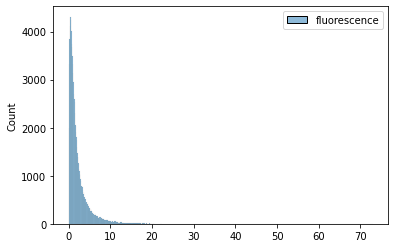

In [7]:
sns.histplot(df[["fluorescence"]])

<AxesSubplot:ylabel='Count'>

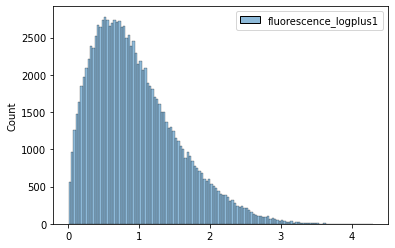

In [8]:
sns.histplot(df[["fluorescence_logplus1"]])

## Create dataset for Tensorflow model

In [9]:
# df["RKA_level"] = df.RKA.apply(RKA_bin)
# df["MFE_level"] = df.RKA.apply(MFE_bin)
# target = df[["MFE_level","RKA_level"]].copy()
sequences = df[["promoter"]].copy()
seq_spaced = sequences.applymap(cutWord)

vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=d_model, standardize='lower_and_strip_punctuation', split='whitespace', ngrams=None, output_mode='int')
vectorize_layer.adapt(seq_spaced)

#Divide to train and test
X_train, X_test, y_train, y_test = train_test_split(seq_spaced, df["fluorescence_logplus1"], test_size=0.33, random_state=42)
#vec_seq = vectorize_layer(X_train)
#seq_database = v

all_vec_seq = vectorize_layer(seq_spaced)
all_vec_seq = tf.data.Dataset.from_tensor_slices(all_vec_seq)
#target_database = tf.data.Dataset.from_tensor_slices(y_train)
target_database = tf.data.Dataset.from_tensor_slices(df["fluorescence_logplus1"])
x_test_database = vectorize_layer(X_test)
x_test_database = tf.data.Dataset.from_tensor_slices(x_test_database)
y_test_database = tf.data.Dataset.from_tensor_slices(y_test)


<AxesSubplot:xlabel='fluorescence_logplus1', ylabel='Count'>

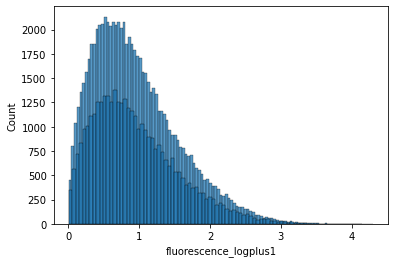

In [10]:
sns.histplot(y_train);sns.histplot(y_test)

In [11]:
#train_set = tf.data.Dataset.zip((seq_database, target_database))
train_set = tf.data.Dataset.zip((all_vec_seq, target_database))
test_dataset = tf.data.Dataset.zip((x_test_database, y_test_database))
real_train_set = train_set.batch(batch_size).shuffle(batch_size)
test_dataset = test_dataset.batch(batch_size)
#next(iter(train_set.batch(10)))

## Build Encoder of Transformer model

### Self attention

In [12]:
def scaled_dot_product_attention(q, k, v, mask=None):
    matmul_qk = tf.matmul(q, k, transpose_b=True) # Shape = (..., seq_len_q, seq_len_k)
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    # calculate matmul_qk_v
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights, matmul_qk

#create multi-head attention layer
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        #Because for multi-head, head number * depth = multi-head
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads

        #Set layers for q, k, v
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
    
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) # shape = (batch_size, num_heads, seq_len, depth)

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights, matmul_qk= scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights, matmul_qk

### Fully connected layer and Encoder layer

In [13]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
        ])
        
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        #define layers
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):

        attn_output, attn_weight, matmul_qk = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2, attn_weight, matmul_qk


### Position Encoding

In [14]:
def get_angles(pos, i, d_model):
    angle_rate = 1/np.power(10000, (2*(i/2))/np.float32(d_model))
    return pos*angle_rate

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :]
                            ,d_model)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [15]:
positional_encoding(1, 9)

<tf.Tensor: shape=(1, 1, 9), dtype=float32, numpy=array([[[0., 1., 0., 1., 0., 1., 0., 1., 0.]]], dtype=float32)>

### Encoder

In [16]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.3):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers #how many encoder layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        self.attention_weights = {}
        self.matmul_qks = {}
        
    def call(self, x, training, mask=None):
        #attention_weights = {}
        #encoding and position encoding
        seq_len = tf.shape(x)[1]
        x = self.embedding(x) # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block, matmul_qk = self.enc_layers[i](x, training, mask)
            self.attention_weights[f'attentions_{i+1}'] = block
            self.matmul_qks[f'matmul_qk_{i+1}'] = matmul_qk
            
        #attention_weights[f'decoder_layer{i+1}_block'] = block
        return x, block # (batch_size, input_seq_len, d_model)
    
    def get_attention(self):
        return self.attention_weights
    def get_matmul_qks(self):
        return self.matmul_qks

### Test of Encoder

In [17]:
sample_encoder = Encoder(num_layers=2, d_model=5, num_heads=1,
                         dff=dff, input_vocab_size=10,
                         maximum_position_encoding=30)
temp_input = vectorize_layer(seq_spaced)
#temp_input = tf.random.uniform((3, 24), dtype=tf.int64, minval=0, maxval=200)
sample_encoder_output = sample_encoder(temp_input[22:29], training=False, mask=None)
sample_encoder_output[0].shape

TensorShape([7, 29, 5])

## Create model

In [18]:
def create_model(seq_length, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.3):
    input = tf.keras.Input(shape=(seq_length,))
    x , aws= Encoder(num_layers, d_model, num_heads, dff,
                input_vocab_size, maximum_position_encoding, rate=rate)(input)
    x = tf.keras.layers.Reshape((seq_length*d_model,))(x)
    x = tf.keras.layers.Dense(seq_length, activation='relu')(x)
    x = tf.keras.layers.Dense(1)(x)
    output = tf.squeeze(x)
    
    return tf.keras.Model(inputs=input, outputs=output)
    

In [19]:
model = create_model(seq_length=seq_length, num_layers= num_layers, d_model=d_model, num_heads=num_heads,
                         dff=dff, input_vocab_size=10,
                         maximum_position_encoding=30)
p = vectorize_layer(seq_spaced.iloc[17])
model(p)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.13969502>

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 encoder_1 (Encoder)         ((None, 29, 128),         397824    
                              (None, 8, None, None))             
                                                                 
 reshape (Reshape)           (None, 3712)              0         
                                                                 
 dense_24 (Dense)            (None, 29)                107677    
                                                                 
 dense_25 (Dense)            (None, 1)                 30        
                                                                 
 tf.compat.v1.squeeze (TFOp  None                      0         
 Lambda)                                                     

## Test our model to see if it can work and get the attention matrix

<AxesSubplot:>

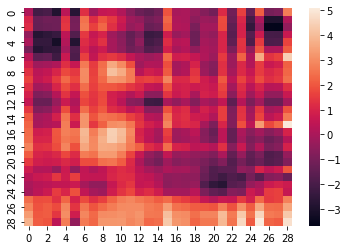

In [21]:
for i in real_train_set.take(1):
    q = model(i[0])
att = model.layers[1].get_attention()['attentions_1']
qk = model.layers[1].get_matmul_qks()['matmul_qk_1']
#forheat = tf.squeeze(att).numpy()
sns.heatmap(qk[(0,0)])

## Custom Schedule/ Accuracy/ Loss functions

In [22]:
class RSquare(tf.keras.metrics.Metric):
    def __init__(self, name='r_square', **kwargs):
        super(RSquare, self).__init__(name=name, **kwargs)
        self.sse = self.add_weight(name='sse', initializer='zeros')
        self.sst = self.add_weight(name='sst', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weigth=None):
        y_true = tf.cast(y_true, tf.float32)
        error = y_true - y_pred
        self.sse.assign_add(tf.reduce_sum(tf.square(error)))
        self.sst.assign_add(tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))))
        
    def result(self):
        return 1 - (self.sse / self.sst)
    
    def reset_states(self):
        self.sse.assign(0)
        self.sst.assign(0)

In [23]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
#optimizer = tf.keras.optimizers.Adam()

#loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
loss_object = loss=tf.keras.losses.MeanAbsoluteError()

def loss_function(real, pred):
    #mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    #mask = tf.cast(mask, dtype=loss_.dtype)
    #loss_ *= mask
    #return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
    return tf.reduce_sum(loss_)


def accuracy_function(real, pred):
    accuracies = loss_object(real, pred)
    #accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    #accuracies = tf.keras.losses.MeanAbsoluteError(real, pred)
    #mask = tf.math.logical_not(tf.math.equal(real, 0))
    #accuracies = tf.math.logical_and(mask, accuracies)
    #accuracies = tf.cast(accuracies, dtype=tf.float32)
    #mask = tf.cast(mask, dtype=tf.float32)
    #return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)
    return tf.reduce_sum(accuracies)

train_metric = RSquare()
test_metric = RSquare()

train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')

In [24]:
 
checkpoint_path = "./checkpoints_64_21_pos/"+"model" +'_' + str(num_layers) + '_'+ str(num_heads) + '_' + str(d_model) + '_' + str(dff)

ckpt = tf.train.Checkpoint(transformer=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

Latest checkpoint restored!!


## Customized Train/Test steps

If you face some type mismatch, please use pip install typeguard==2.13.3.
typeguard 3.0.0 version was released recently that's the reason why it's not working.

Source: https://stackoverflow.com/questions/75759597/typeerror-isinstance-arg-2-must-be-a-type-or-tuple-of-types-in-tensorflow-add

In [25]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

#train_step_signature = [
#    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
#    tf.TensorSpec(shape=(None), dtype=tf.int64),
#]


#@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    #inp = inp
    target = tar

    with tf.GradientTape() as tape:
        predictions = model(inp, training = True)
        loss = loss_function(target, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)

    train_metric.update_state(target, predictions)
    #result = metric.result()
    #train_accuracy(result)
    #train_accuracy(accuracy_function(target, predictions))
    
def test_step(model, inp, tar):
    #inp = inp
    target = tar
    predictions = model(inp)
    testloss = loss_function(tar, predictions)
    test_loss(testloss)
    test_metric.update_state(target, predictions)

    #result = metric.result()
    #test_accuracy(result)

    #train_accuracy(accuracy_function(target, predictions))

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '_' + str(num_layers) + '_'+ str(num_heads) + '_' + str(d_model) + '_' + str(dff)+ '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '_' + str(num_layers) + '_'+ str(num_heads) + '_' + str(d_model) + '_' + str(dff)+  '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

## Train loop

In [148]:
import time
EPOCHS= 500

for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()


  for (batch, (inp, tar)) in enumerate(real_train_set):
    train_step(inp, tar)
    if batch % 300 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_metric.result():.4f}')

  with train_summary_writer.as_default():
    tf.summary.scalar('loss', train_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', train_metric.result(), step=epoch)

  for (batch, (inp, tar)) in enumerate(test_dataset):
    test_step(model, inp, tar)

  with test_summary_writer.as_default():
    tf.summary.scalar('loss', test_loss.result(), step=epoch)
    tf.summary.scalar('accuracy_test', test_metric.result(), step=epoch)

  template = 'Epoch {}, Loss: {}, Test Loss: {}, Test R^2: {}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         test_loss.result(),
                         test_metric.result()
                         ))
  #Print out information
 

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_metric.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
  # if early_stopping.monitor_op(test_loss.result()):
  #   print("Validation loss is not decreasing. Stopping training.")
  #   break

Epoch 1 Batch 0 Loss 0.2356 Accuracy 0.6614
Epoch 1, Loss: 0.24634769558906555, Test Loss: 0.2230440080165863, Test R^2: 0.7144866585731506
Epoch 2 Batch 0 Loss 0.2442 Accuracy 0.6623
Epoch 2, Loss: 0.24719855189323425, Test Loss: 0.22859635949134827, Test R^2: 0.7078688740730286
Epoch 3 Batch 0 Loss 0.2472 Accuracy 0.6620
Epoch 3, Loss: 0.24665646255016327, Test Loss: 0.23016738891601562, Test R^2: 0.7050865292549133
Epoch 4 Batch 0 Loss 0.2501 Accuracy 0.6625
Epoch 4, Loss: 0.2476160079240799, Test Loss: 0.22977697849273682, Test R^2: 0.7055085301399231
Epoch 5 Batch 0 Loss 0.2373 Accuracy 0.6620
Epoch 5, Loss: 0.2465192824602127, Test Loss: 0.23038695752620697, Test R^2: 0.7049212455749512
Saving checkpoint for epoch 5 at ./checkpoints_64_21_pos_周/model_2_8_128_512/ckpt-101
Epoch 5 Loss 0.2465 Accuracy 0.6620
Time taken for 1 epoch: 124.00 secs

Epoch 6 Batch 0 Loss 0.2407 Accuracy 0.6620
Epoch 6, Loss: 0.24624137580394745, Test Loss: 0.23003128170967102, Test R^2: 0.705295741558075

Epoch 49 Batch 0 Loss 0.2558 Accuracy 0.6648
Epoch 49, Loss: 0.24426105618476868, Test Loss: 0.22877223789691925, Test R^2: 0.7081043124198914
Epoch 50 Batch 0 Loss 0.2435 Accuracy 0.6648
Epoch 50, Loss: 0.24430659413337708, Test Loss: 0.22872032225131989, Test R^2: 0.7082226276397705
Saving checkpoint for epoch 50 at ./checkpoints_64_21_pos_周/model_2_8_128_512/ckpt-110
Epoch 50 Loss 0.2443 Accuracy 0.6649
Time taken for 1 epoch: 123.58 secs

Epoch 51 Batch 0 Loss 0.1734 Accuracy 0.6649
Epoch 51, Loss: 0.24397379159927368, Test Loss: 0.22870048880577087, Test R^2: 0.7082616090774536
Epoch 52 Batch 0 Loss 0.2280 Accuracy 0.6650
Epoch 52, Loss: 0.24390435218811035, Test Loss: 0.2285510152578354, Test R^2: 0.7085440754890442
Epoch 53 Batch 0 Loss 0.2465 Accuracy 0.6651
Epoch 53, Loss: 0.24411171674728394, Test Loss: 0.22857354581356049, Test R^2: 0.7085603475570679
Epoch 54 Batch 0 Loss 0.2420 Accuracy 0.6651
Epoch 54, Loss: 0.24424564838409424, Test Loss: 0.22850528359413147, Test R^2: 0

Epoch 96 Batch 0 Loss 0.2348 Accuracy 0.6674
Epoch 96, Loss: 0.243296816945076, Test Loss: 0.22678278386592865, Test R^2: 0.7123000621795654
Epoch 97 Batch 0 Loss 0.2440 Accuracy 0.6675
Epoch 97, Loss: 0.24229517579078674, Test Loss: 0.22669146955013275, Test R^2: 0.7124416828155518
Epoch 98 Batch 0 Loss 0.2637 Accuracy 0.6675
Epoch 98, Loss: 0.24263687431812286, Test Loss: 0.22661365568637848, Test R^2: 0.7125861644744873
Epoch 99 Batch 0 Loss 0.2401 Accuracy 0.6676
Epoch 99, Loss: 0.24317236244678497, Test Loss: 0.2265436351299286, Test R^2: 0.7127525806427002
Epoch 100 Batch 0 Loss 0.2550 Accuracy 0.6676
Epoch 100, Loss: 0.24226947128772736, Test Loss: 0.22658997774124146, Test R^2: 0.712695300579071
Saving checkpoint for epoch 100 at ./checkpoints_64_21_pos_周/model_2_8_128_512/ckpt-120
Epoch 100 Loss 0.2423 Accuracy 0.6677
Time taken for 1 epoch: 109.21 secs

Epoch 101 Batch 0 Loss 0.2415 Accuracy 0.6677
Epoch 101, Loss: 0.24247804284095764, Test Loss: 0.22661063075065613, Test R^2

Epoch 143 Batch 0 Loss 0.2341 Accuracy 0.6699
Epoch 143, Loss: 0.24103714525699615, Test Loss: 0.22551512718200684, Test R^2: 0.7152965068817139
Epoch 144 Batch 0 Loss 0.2498 Accuracy 0.6700
Epoch 144, Loss: 0.24047182500362396, Test Loss: 0.22545918822288513, Test R^2: 0.7153991460800171
Epoch 145 Batch 0 Loss 0.2415 Accuracy 0.6700
Epoch 145, Loss: 0.24078088998794556, Test Loss: 0.2254677563905716, Test R^2: 0.7153931856155396
Saving checkpoint for epoch 145 at ./checkpoints_64_21_pos_周/model_2_8_128_512/ckpt-129
Epoch 145 Loss 0.2408 Accuracy 0.6701
Time taken for 1 epoch: 109.35 secs

Epoch 146 Batch 0 Loss 0.2494 Accuracy 0.6701
Epoch 146, Loss: 0.2416595220565796, Test Loss: 0.22541098296642303, Test R^2: 0.7155052423477173
Epoch 147 Batch 0 Loss 0.2465 Accuracy 0.6701
Epoch 147, Loss: 0.2408621609210968, Test Loss: 0.22544270753860474, Test R^2: 0.7154720425605774
Epoch 148 Batch 0 Loss 0.2439 Accuracy 0.6702
Epoch 148, Loss: 0.24055930972099304, Test Loss: 0.22545446455478668,

Epoch 190 Batch 0 Loss 0.2548 Accuracy 0.6723
Epoch 190, Loss: 0.23932132124900818, Test Loss: 0.22414915263652802, Test R^2: 0.7182601094245911
Saving checkpoint for epoch 190 at ./checkpoints_64_21_pos_周/model_2_8_128_512/ckpt-138
Epoch 190 Loss 0.2393 Accuracy 0.6723
Time taken for 1 epoch: 109.38 secs

Epoch 191 Batch 0 Loss 0.2645 Accuracy 0.6723
Epoch 191, Loss: 0.23862352967262268, Test Loss: 0.2241252064704895, Test R^2: 0.7183102965354919
Epoch 192 Batch 0 Loss 0.2375 Accuracy 0.6724
Epoch 192, Loss: 0.23906093835830688, Test Loss: 0.2241024225950241, Test R^2: 0.7183612585067749
Epoch 193 Batch 0 Loss 0.2539 Accuracy 0.6724
Epoch 193, Loss: 0.2392898052930832, Test Loss: 0.22404643893241882, Test R^2: 0.7184568643569946
Epoch 194 Batch 0 Loss 0.2410 Accuracy 0.6725
Epoch 194, Loss: 0.23900963366031647, Test Loss: 0.2240416556596756, Test R^2: 0.7184863090515137
Epoch 195 Batch 0 Loss 0.2472 Accuracy 0.6725
Epoch 195, Loss: 0.23883862793445587, Test Loss: 0.22406361997127533, 

Epoch 236 Batch 0 Loss 0.2572 Accuracy 0.6744
Epoch 236, Loss: 0.23787347972393036, Test Loss: 0.22302857041358948, Test R^2: 0.7207076549530029
Epoch 237 Batch 0 Loss 0.2323 Accuracy 0.6745
Epoch 237, Loss: 0.23722966015338898, Test Loss: 0.22303062677383423, Test R^2: 0.7207191586494446
Epoch 238 Batch 0 Loss 0.2367 Accuracy 0.6745
Epoch 238, Loss: 0.2367842048406601, Test Loss: 0.22304262220859528, Test R^2: 0.7207196950912476
Epoch 239 Batch 0 Loss 0.2467 Accuracy 0.6746
Epoch 239, Loss: 0.23751726746559143, Test Loss: 0.2230234444141388, Test R^2: 0.7207645773887634
Epoch 240 Batch 0 Loss 0.2225 Accuracy 0.6746
Epoch 240, Loss: 0.2374137043952942, Test Loss: 0.22298669815063477, Test R^2: 0.720838189125061
Saving checkpoint for epoch 240 at ./checkpoints_64_21_pos_周/model_2_8_128_512/ckpt-148
Epoch 240 Loss 0.2374 Accuracy 0.6747
Time taken for 1 epoch: 109.26 secs

Epoch 241 Batch 0 Loss 0.2363 Accuracy 0.6747
Epoch 241, Loss: 0.23743592202663422, Test Loss: 0.22295774519443512, 

Epoch 283 Batch 0 Loss 0.2362 Accuracy 0.6765
Epoch 283, Loss: 0.23624546825885773, Test Loss: 0.22195111215114594, Test R^2: 0.7230985760688782
Epoch 284 Batch 0 Loss 0.2511 Accuracy 0.6766
Epoch 284, Loss: 0.23576313257217407, Test Loss: 0.22195474803447723, Test R^2: 0.7231076955795288
Epoch 285 Batch 0 Loss 0.2282 Accuracy 0.6766
Epoch 285, Loss: 0.23649050295352936, Test Loss: 0.22193753719329834, Test R^2: 0.7231488227844238
Saving checkpoint for epoch 285 at ./checkpoints_64_21_pos_周/model_2_8_128_512/ckpt-157
Epoch 285 Loss 0.2365 Accuracy 0.6767
Time taken for 1 epoch: 109.25 secs

Epoch 286 Batch 0 Loss 0.2349 Accuracy 0.6767
Epoch 286, Loss: 0.23593273758888245, Test Loss: 0.22191831469535828, Test R^2: 0.7231909036636353
Epoch 287 Batch 0 Loss 0.2478 Accuracy 0.6767
Epoch 287, Loss: 0.235746830701828, Test Loss: 0.2219240516424179, Test R^2: 0.7232010364532471
Epoch 288 Batch 0 Loss 0.2292 Accuracy 0.6768
Epoch 288, Loss: 0.2360748052597046, Test Loss: 0.22188939154148102, 

Epoch 330 Batch 0 Loss 0.2365 Accuracy 0.6785
Epoch 330, Loss: 0.23508894443511963, Test Loss: 0.22081539034843445, Test R^2: 0.725490927696228
Saving checkpoint for epoch 330 at ./checkpoints_64_21_pos_周/model_2_8_128_512/ckpt-166
Epoch 330 Loss 0.2351 Accuracy 0.6786
Time taken for 1 epoch: 109.27 secs

Epoch 331 Batch 0 Loss 0.2169 Accuracy 0.6786
Epoch 331, Loss: 0.2350955605506897, Test Loss: 0.22078999876976013, Test R^2: 0.7255452871322632
Epoch 332 Batch 0 Loss 0.2239 Accuracy 0.6786
Epoch 332, Loss: 0.23508518934249878, Test Loss: 0.22075505554676056, Test R^2: 0.7256079912185669
Epoch 333 Batch 0 Loss 0.2159 Accuracy 0.6786
Epoch 333, Loss: 0.23445609211921692, Test Loss: 0.22073346376419067, Test R^2: 0.7256606817245483
Epoch 334 Batch 0 Loss 0.2340 Accuracy 0.6787
Epoch 334, Loss: 0.23487941920757294, Test Loss: 0.22070567309856415, Test R^2: 0.7257169485092163
Epoch 335 Batch 0 Loss 0.2615 Accuracy 0.6787
Epoch 335, Loss: 0.23482562601566315, Test Loss: 0.220688134431839, 

Epoch 376 Batch 0 Loss 0.2399 Accuracy 0.6803
Epoch 376, Loss: 0.23380525410175323, Test Loss: 0.21978303790092468, Test R^2: 0.7277382612228394
Epoch 377 Batch 0 Loss 0.2412 Accuracy 0.6804
Epoch 377, Loss: 0.23437657952308655, Test Loss: 0.21977366507053375, Test R^2: 0.7277671098709106
Epoch 378 Batch 0 Loss 0.2371 Accuracy 0.6804
Epoch 378, Loss: 0.23338735103607178, Test Loss: 0.2197486311197281, Test R^2: 0.7278202176094055
Epoch 379 Batch 0 Loss 0.2230 Accuracy 0.6805
Epoch 379, Loss: 0.2339075803756714, Test Loss: 0.2197260558605194, Test R^2: 0.7278659343719482
Epoch 380 Batch 0 Loss 0.2431 Accuracy 0.6805
Epoch 380, Loss: 0.23325124382972717, Test Loss: 0.21970701217651367, Test R^2: 0.727911114692688
Saving checkpoint for epoch 380 at ./checkpoints_64_21_pos_周/model_2_8_128_512/ckpt-176
Epoch 380 Loss 0.2333 Accuracy 0.6805
Time taken for 1 epoch: 109.26 secs

Epoch 381 Batch 0 Loss 0.2373 Accuracy 0.6805
Epoch 381, Loss: 0.23361198604106903, Test Loss: 0.21969285607337952, 

Epoch 423 Batch 0 Loss 0.2354 Accuracy 0.6821
Epoch 423, Loss: 0.23260417580604553, Test Loss: 0.21893706917762756, Test R^2: 0.7297152280807495
Epoch 424 Batch 0 Loss 0.2427 Accuracy 0.6821
Epoch 424, Loss: 0.23370486497879028, Test Loss: 0.21891772747039795, Test R^2: 0.7297621369361877
Epoch 425 Batch 0 Loss 0.2425 Accuracy 0.6822
Epoch 425, Loss: 0.23247598111629486, Test Loss: 0.21891820430755615, Test R^2: 0.7297790050506592
Saving checkpoint for epoch 425 at ./checkpoints_64_21_pos_周/model_2_8_128_512/ckpt-185
Epoch 425 Loss 0.2325 Accuracy 0.6822
Time taken for 1 epoch: 109.21 secs

Epoch 426 Batch 0 Loss 0.2543 Accuracy 0.6822
Epoch 426, Loss: 0.23265253007411957, Test Loss: 0.2188934087753296, Test R^2: 0.7298314571380615
Epoch 427 Batch 0 Loss 0.2435 Accuracy 0.6822
Epoch 427, Loss: 0.23244963586330414, Test Loss: 0.21888087689876556, Test R^2: 0.7298663258552551
Epoch 428 Batch 0 Loss 0.2338 Accuracy 0.6823
Epoch 428, Loss: 0.2327979952096939, Test Loss: 0.21886548399925232

Epoch 470 Batch 0 Loss 0.2382 Accuracy 0.6838
Epoch 470, Loss: 0.23137320578098297, Test Loss: 0.21804513037204742, Test R^2: 0.7317029237747192
Saving checkpoint for epoch 470 at ./checkpoints_64_21_pos_周/model_2_8_128_512/ckpt-194
Epoch 470 Loss 0.2314 Accuracy 0.6838
Time taken for 1 epoch: 109.35 secs

Epoch 471 Batch 0 Loss 0.2365 Accuracy 0.6838
Epoch 471, Loss: 0.23155836760997772, Test Loss: 0.21802861988544464, Test R^2: 0.7317419052124023
Epoch 472 Batch 0 Loss 0.2309 Accuracy 0.6838
Epoch 472, Loss: 0.23243801295757294, Test Loss: 0.21803314983844757, Test R^2: 0.7317538261413574
Epoch 473 Batch 0 Loss 0.2377 Accuracy 0.6839
Epoch 473, Loss: 0.23134678602218628, Test Loss: 0.21802444756031036, Test R^2: 0.7317847013473511
Epoch 474 Batch 0 Loss 0.2226 Accuracy 0.6839
Epoch 474, Loss: 0.2321256548166275, Test Loss: 0.21800704300403595, Test R^2: 0.7318258881568909
Epoch 475 Batch 0 Loss 0.2297 Accuracy 0.6839
Epoch 475, Loss: 0.23222757875919342, Test Loss: 0.2179760634899139

In [234]:
#save the model
model.save('./checkpoints_64_21_pos/model_2_8_128_512/model')

## Visualize attentions

In [25]:
df["seq_spaced"] = seq_spaced
def visualize_attention(heads, labels, attention):
    plt.rcParams["figure.figsize"] = (20,5)
    fig, axs = plt.subplots(1,heads)
    plt.set_cmap('bwr')
    for i in range(heads):
        ax = axs[i]
        cax = ax.matshow(attention[i])
        ax.set_xticks(range(len(labels)))
        ax.set_yticks(range(len(labels)))
        #labels = [label for label in R.to_numpy()[0]]
        ax.set_xticklabels(labels, rotation=90)
        #labels = [label for label in R.to_numpy()[0]]
        ax.set_yticklabels(labels)
        print(f"head{i}: {tf.reduce_max(attention[i])}")
        print(f"head{i}: {tf.reduce_min(attention[i])}")
    cbar = fig.colorbar(cax)

def plot_attention_head(sequence, attention, heads):
    # The plot is of the attention when a token was generated.
    # # The model didn't generate `<START>` in the output. Skip it.
    labels = [label for label in sequence.to_numpy()[0]]
    #translated_tokens = translated_tokens[1:]
    #ax = plt.gca()
    visualize_attention(heads = heads, labels=labels, attention=attention)
    
   

## Test individual sequence

In [26]:
# seq = 'AAAACAGGCGCCTCGAGTCCTTGTATAAT'
# sequence_demo = df[df.promoter == seq].seq_spaced
# rka_for_show = df[df.promoter == seq].fluorescence_logplus1
# p = vectorize_layer(sequence_demo)
# result = model(p)
# att = model.layers[1].get_attention()['attentions_1'][0]
# matmul_qk_s = model.layers[1].get_matmul_qks()['matmul_qk_1'][0]
# R = sequence_demo.str.split(" ")

# plot_attention_head(R,matmul_qk_s, num_heads)
# print('sequence: ', sequence_demo.to_numpy())
# print(f'predicted fluorescence: {result.numpy()}, real fluorescence {rka_for_show}')

## Verify the predicted result

In [27]:
result = model.predict(x_test_database.batch(1024))
result.shape

37/37 [==============================] - 8s 214ms/step


(37276,)

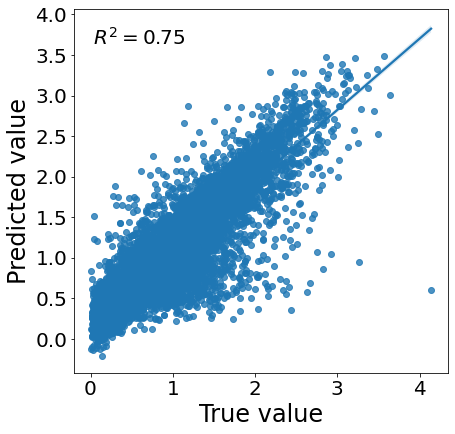

In [28]:
import statsmodels.api as sm

y_test = y_test.reset_index(drop=True)

np.random.seed(0)

random_indices = np.random.choice(len(y_test), size=10000, replace=False)

random_y_test = y_test[random_indices]
random_result = result[random_indices]


# Line regressive
X = sm.add_constant(random_y_test)
model = sm.OLS(random_y_test, X).fit()

# Calculate R^2
from sklearn.metrics import r2_score
r2_score = r2_score(y_test, result)

plt.rcParams["figure.figsize"] = (6.7,6.7)
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 24
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
sns.regplot(x=random_y_test, y=random_result, ci=95)

#Add R2 and p_value
plt.text(0.05, 0.95, f'$R^2 = {r2_score:.2f}$',
       ha='left', va='top', transform=plt.gca().transAxes)

plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.savefig("./checkpoints_64_21_pos/"+"model" +'_' + str(num_layers) + '_'+ str(num_heads) + '_' + str(d_model) + '_' + str(dff)+'/True_Predicted.pdf')


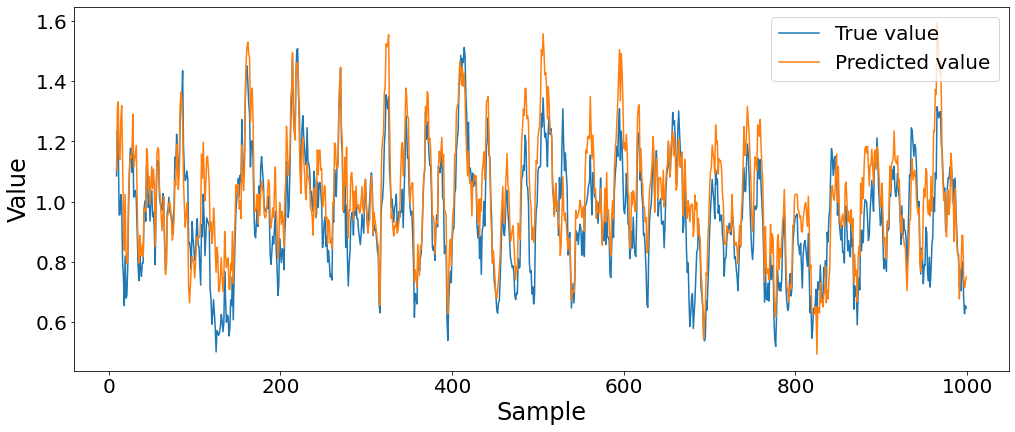

In [29]:
result.shape, y_test.shape
plt.rcParams["figure.figsize"] = (16.75,6.7)
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 24
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
sns.lineplot(data=pd.Series(y_test)[:1000].rolling(10).mean() ,label="True value")
sns.lineplot(data=pd.Series(result)[:1000].rolling(10).mean(), label="Predicted value")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.savefig("./checkpoints_64_21_pos/"+"model" +'_' + str(num_layers) + '_'+ str(num_heads) + '_' + str(d_model) + '_' + str(dff)+'/True_Predicted_line.pdf')

In [30]:
# Calculate R^2
from sklearn.metrics import r2_score
r2_score(y_test, result)

0.7474384758176664

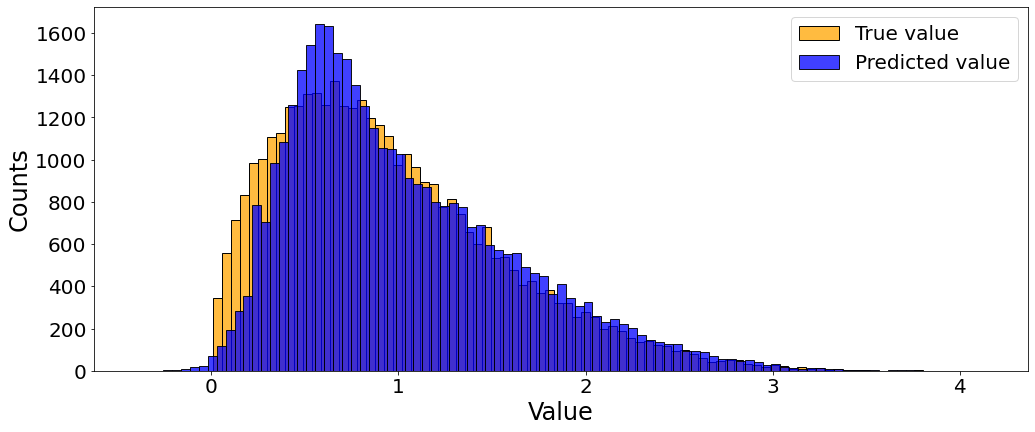

In [31]:
plt.rcParams["figure.figsize"] = (16.75,6.7)
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 24
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
sns.histplot(y_test, color = "orange", label = "True value")
sns.histplot(result, color = "blue", label = "Predicted value")
plt.legend(loc = "upper right")
plt.xlabel("Value")
plt.ylabel("Counts")
plt.savefig("./checkpoints_64_21_pos/"+"model" +'_' + str(num_layers) + '_'+ str(num_heads) + '_' + str(d_model) + '_' + str(dff)+'/histplot.pdf')



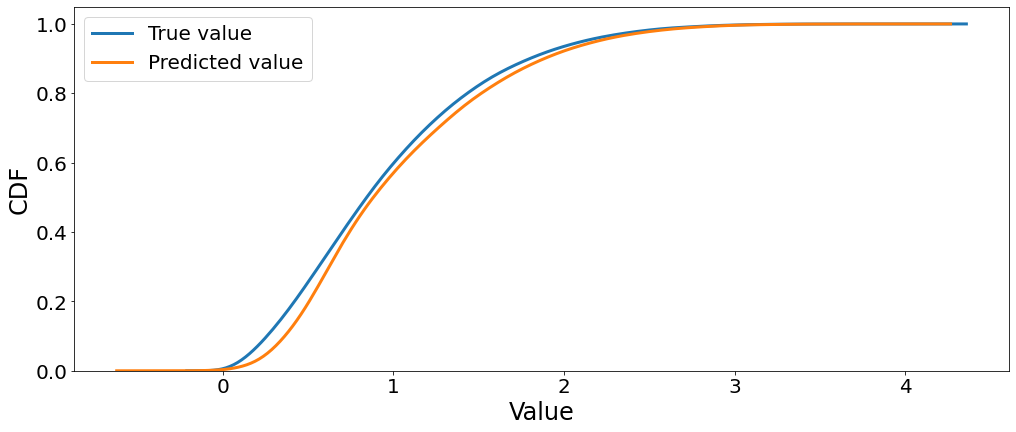

In [32]:
import seaborn as sns

plt.figure(figsize=(16.75,6.7))
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 24
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20

sns.kdeplot(y_test, cumulative=True, label='True value', linewidth=3)
sns.kdeplot(result, cumulative=True, label='Predicted value', linewidth=3)

plt.xlabel('Value')
plt.ylabel('CDF')
plt.legend()

plt.savefig("./checkpoints_64_21_pos/"+"model" +'_' + str(num_layers) + '_'+ str(num_heads) + '_' + str(d_model) + '_' + str(dff)+'/CDF.pdf')


In [33]:
from scipy.stats import ks_2samp
from pyemd import emd_samples

actual = y_test
predicted = result

ks_stat, p_value = ks_2samp(actual, predicted)
print(f'KS Statistic: {ks_stat}, P-value: {p_value}')

emd_value = emd_samples(actual, predicted)
print(f'EMD: {emd_value}')

def area_difference(cdf1, cdf2, bin_edges):
    return np.sum(np.abs(cdf1 - cdf2) * np.diff(bin_edges))

counts_actual, bin_edges_actual = np.histogram(actual, bins=100, density=True)
cdf_actual = np.cumsum(counts_actual) / np.sum(counts_actual)

counts_predicted, bin_edges_predicted = np.histogram(predicted, bins=100, density=True)
cdf_predicted = np.cumsum(counts_predicted) / np.sum(counts_predicted)

common_bin_edges = np.linspace(min(bin_edges_actual[0], bin_edges_predicted[0]), 
                               max(bin_edges_actual[-1], bin_edges_predicted[-1]), 101)

counts_actual, _ = np.histogram(actual, bins=common_bin_edges, density=True)
cdf_actual = np.cumsum(counts_actual) / np.sum(counts_actual)

counts_predicted, _ = np.histogram(predicted, bins=common_bin_edges, density=True)
cdf_predicted = np.cumsum(counts_predicted) / np.sum(counts_predicted)

area_diff = area_difference(cdf_actual, cdf_predicted, common_bin_edges)
print(f'Area Difference between CDFs: {area_diff}')

KS Statistic: 0.0683281467968666, P-value: 5.2478808971856804e-76
EMD: 0.06989609056229307
Area Difference between CDFs: 0.06985381267404041
